In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import math
import scipy
from scipy.special import erf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects
from mpl_toolkits.mplot3d import Axes3D

In [2]:
plt.rcParams.update({'font.size': 22})
plt.rcParams["figure.figsize"] = (9, 6)

In [3]:
def generateLine(m,b,sigma,n_train,n_valid):
    x_train = np.random.uniform(-1, 1, n_train)
    x_valid = np.random.uniform(-1, 1, n_valid)
    x_valid.sort()
    y_target = m * x_valid + b # ideal (target) linear function

    y_train = np.random.normal(m * x_train + b, sigma) # actual measures from which we want to guess regression parameters
    y_valid = np.random.normal(m * x_valid + b, sigma)
    return x_train,y_train,x_valid,y_valid

In [4]:
#generate a training set of size n_train and a valid set of size n_valid of points lying 
#on the polynomial with coefficients given in coeffs with a gaussian noise with STD sigma
def generatePolynomial(coeffs,sigma,n_train,n_valid):
    x_train = np.random.uniform(-1, 1, n_train)
    x_valid = np.random.uniform(-1, 1, n_valid)
    x_valid.sort()
    y_target = m * x_valid + b # ideal (target) linear function
        
    y_train = np.random.normal(sum([coeffs[i]*x_train**i for i in range(len(coeffs))]), sigma) # actual measures from which we want to guess regression parameters
    y_valid = np.random.normal(sum([coeffs[i]*x_valid**i for i in range(len(coeffs))]), sigma)
    return x_train,y_train,x_valid,y_valid

In [5]:
#generate a training set of size n_train and a valid set of size n_valid of points lying 
#on the function sin(x^2+y^2)
def generateRadialSine(sigma,n_train,n_valid):
    x_train = np.random.uniform(-1.5, 1.5, n_train)
    y_train = np.random.uniform(-1.5, 1.5, n_train)
    x_valid = np.random.uniform(-1.5, 1.5, n_valid)
    y_valid = np.random.uniform(-1.5, 1.5, n_valid)
    z_train = np.sin(x_train**2+y_train**2) # ideal (target) linear function
    z_valid = np.sin(x_valid**2+y_valid**2)+np.random.normal(0,sigma) # ideal (target) linear function
        
    return x_train,y_train,z_train,x_valid,y_valid,z_valid

## Exercise 11.1 ##
In this exercise we are required to use a neural network to fit linear data. At first we generate two sets of data: 

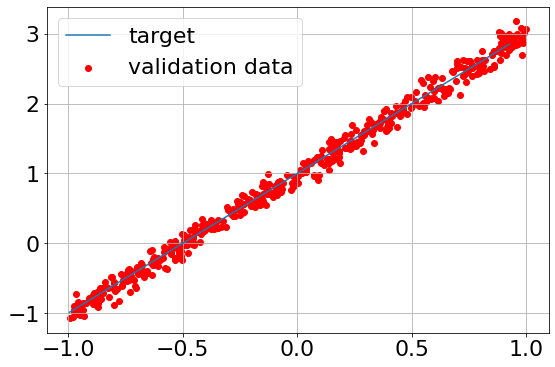

In [6]:
m=2
b=1

n_train=500
n_valid=50

# generate training inputs
np.random.seed(0)
sigma = 0.1 # noise standard deviation, for the moment it is absent

x_train,y_train,x_valid,y_valid=generateLine(m,b,sigma,n_train,n_valid)
y_target=m*x_valid+b
plt.plot(x_valid, y_target, label='target')
plt.scatter(x_train, y_train, color='r', label='validation data')
plt.legend()
plt.grid(True)
plt.show()

We now have to create a model and compile it. Given that a single perceptron is a linear predictor function (i.e. it can classify linear separable data) a single neuron neural network is enough.

In [7]:
model = tf.keras.Sequential()
model.add(Dense(1, input_shape=(1,)))

# compile the model choosing optimizer, loss and metrics objects
model.compile(optimizer='sgd', loss='mse', metrics=['mse'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [9]:
bsize = 32
# fit the model using training dataset
# over 50 epochs of 32 batch size each
# report training progress against validation data
history = model.fit(x=x_train, y=y_train, 
          batch_size=bsize, epochs=50, 
          validation_data=(x_valid, y_valid),
          verbose=0);

In [10]:
w=model.get_weights()
display(f"Il peso del neurone è {w[0][0][0]:.3f}, mentre il bias è {w[1][0]:.3f}")

'Il peso del neurone è 1.996, mentre il bias è 0.989'

As we can see we have exactly the slope and the y-intercept of the line we have chosen. 

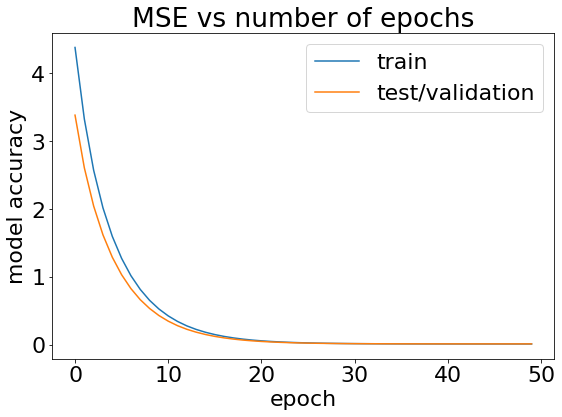

In [11]:
plt.plot(history.history['mse']) #plt.plot(history.history['acc']) #for generic 'accuracy'
plt.plot(history.history['val_mse'])
plt.ylabel('model accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test/validation'], loc='best')
plt.title("MSE vs number of epochs")
plt.show()

We can even try to generate new data with our neural network:


4/4 [==============================] - 0s 3ms/step


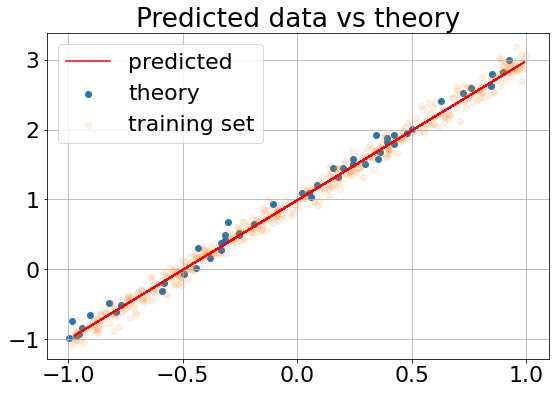

In [12]:
x_predicted = np.random.uniform(-1, 1, 100)
y_predicted = model.predict(x_predicted)
plt.plot(x_predicted, y_predicted,color='r',label='predicted')
plt.scatter(x_valid, y_valid,label='theory')
plt.scatter(x_train,y_train,alpha=0.1,label='training set')
plt.grid(True)
plt.legend()
plt.title('Predicted data vs theory')
plt.show()

Obviously we can look at what happens as the number of epochs and the noise grow

In [13]:
MSEs=[]
sigmas=np.arange(0,1,0.05)
n_train=1000
n_valid=100
for sigma in sigmas:
    x_train,y_train,x_valid,y_valid=generateLine(m,b,sigma,n_train,n_valid)
    history = model.fit(x=x_train, y=y_train, 
          batch_size=bsize, epochs=50, 
          validation_data=(x_valid, y_valid),
          verbose=0);
    MSEs.append(history.history['mse'])

Text(0, 0.5, 'MSE')

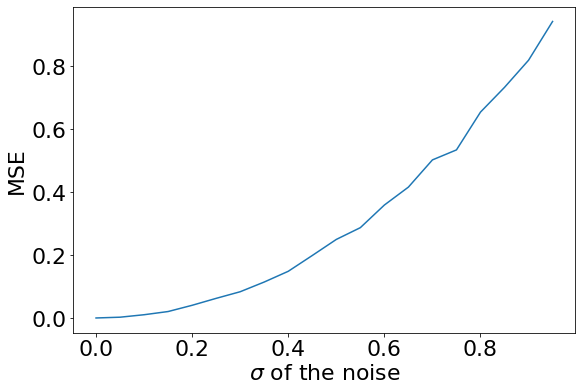

In [14]:
plt.plot(sigmas,[np.mean(MSEs[i]) for i in range(0,len(sigmas))])
plt.xlabel(r'$\sigma$ of the noise')
plt.ylabel('MSE')

As previously stated a single neuron is a linear fitter: even if we add the noise it will try to fit everything with a line. If we add a noise with standard deviation $\sigma$, the expected value of the MSE will be $\sigma^2$: we tried a linear equispaced grid of sigmas and we found a parabola

## Exercise 11.2 ##
We can now go on and try to fit a simple polynomial:
$$f(x)=4-3x-2x^2+3x^3$$
We will generate the data in $[-1,1]$ and we will see how good the fitter behaves inside and outside the interval of the training set 

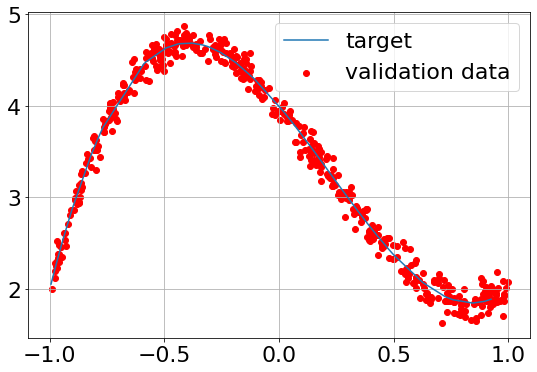

In [15]:
coeffs=[4,-3,-2,3]
n_train=500
n_valid=50

# generate training inputs
np.random.seed(0)
sigma = 0.1 # noise standard deviation, for the moment it is absent

x_train,y_train,x_valid,y_valid=generatePolynomial(coeffs,sigma,n_train,n_valid)
plt.plot(x_valid, sum([coeffs[i]*x_valid**i for i in range(len(coeffs))]), label='target')
plt.scatter(x_train, y_train, color='r', label='validation data')
plt.legend()
plt.grid(True)
plt.show()

We can now generate a model. We can't use anymore a single neuron, so we can start by using 3 layers, with 4 neurons each

In [16]:
keras.backend.clear_session()

model = tf.keras.Sequential()
model.add(Dense(5, input_shape=(1,)))
model.add(Dense(5, activation='elu'))
model.add(Dense(5, activation='elu'))
model.add(Dense(5, activation='elu'))
model.add(Dense(1))

# compile the model choosing optimizer, loss and metrics objects
model.compile(optimizer='sgd', loss='mse', metrics=['mse'])

In [17]:
bsize = 32
history = model.fit(x=x_train, y=y_train, 
          batch_size=bsize, epochs=300, 
          validation_data=(x_valid, y_valid),verbose=0);

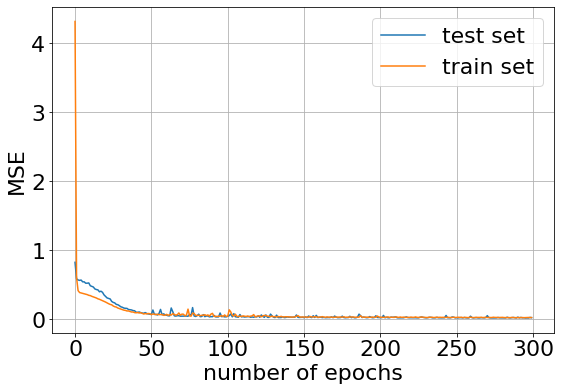

In [18]:
plt.plot(history.history['val_mse'],label='test set')
plt.plot(history.history['mse'],label='train set')
plt.xlabel('number of epochs')
plt.ylabel('MSE')
plt.legend()
plt.grid()

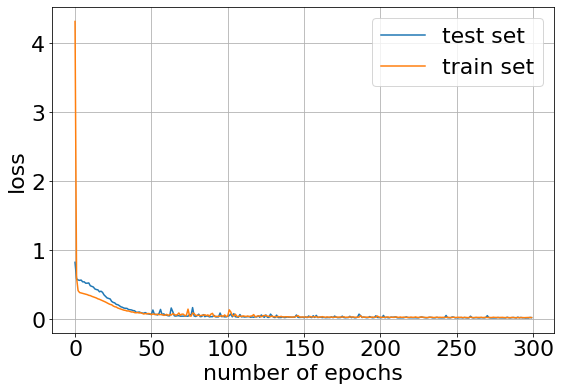

In [19]:
plt.plot(history.history['val_loss'],label='test set')
plt.plot(history.history['loss'],label='train set')
plt.xlabel('number of epochs')
plt.ylabel('loss')
plt.legend()
plt.grid()

4/4 [==============================] - 0s 1ms/step


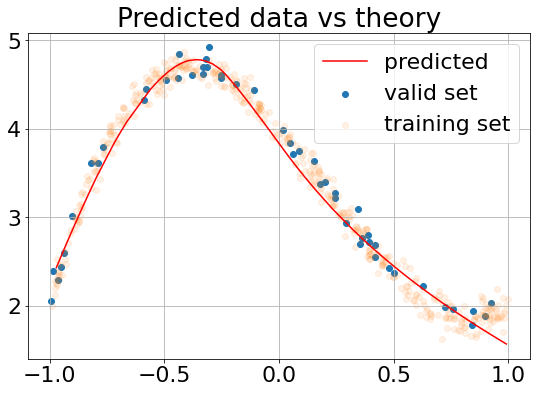

In [20]:
x_predicted = np.sort(np.random.uniform(-1, 1, 100))
y_predicted = np.concatenate(model.predict(x_predicted))
plt.plot(x_predicted, y_predicted,color='r',label='predicted')
plt.scatter(x_valid, y_valid,label='valid set')
plt.scatter(x_train,y_train,alpha=0.1,label='training set')
plt.grid(True)
plt.legend()
plt.title('Predicted data vs theory')
plt.show()

What happens if we try to predict where the data lies outside the interval $[-1,1]$?

32/32 [==============================] - 0s 2ms/step


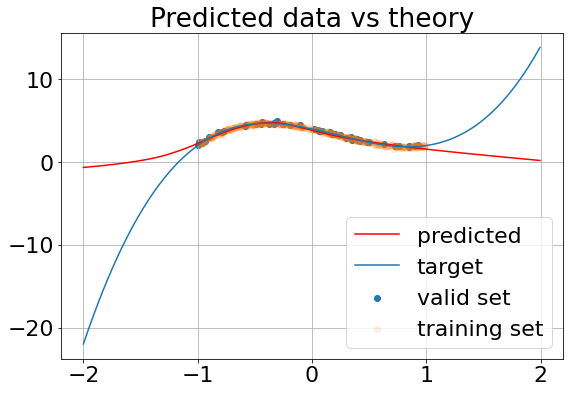

In [21]:
x_predicted = np.sort(np.random.uniform(-2, 2, 1000))
y_predicted = np.concatenate(model.predict(x_predicted))
plt.plot(x_predicted, y_predicted,color='r',label='predicted')
plt.plot(x_predicted, sum([coeffs[i]*x_predicted**i for i in range(len(coeffs))]), label='target')
plt.scatter(x_valid, y_valid,label='valid set')
plt.scatter(x_train,y_train,alpha=0.1,label='training set')
plt.grid(True)
plt.legend()
plt.title('Predicted data vs theory')
plt.show()

As we can clearly see our fit becomes useless really fast outside the interval on which the NN was trained

A lot of reasonable questions may arise: how do we decide the activation function, the number of layers and the number of neurons for each layer? There is no definitive answer, because we really don't know what's going on under the hood. But we can try to see what happens if we use other parameters.

Let's analyze, at first, the effect of the activation function. To do so we generate another network with sigmoidal activation function. Obviously the output layer will still be linear, because we can't return a bounded output

4/4 [==============================] - 0s 3ms/step


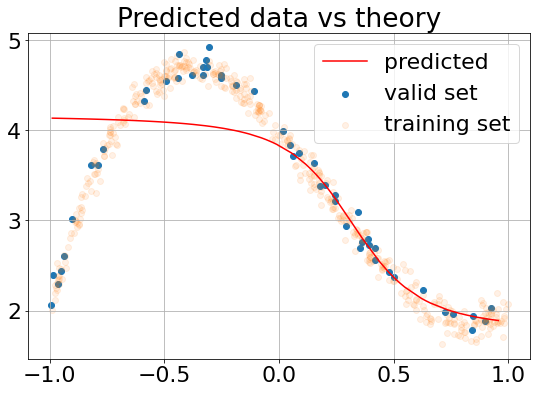

In [22]:
keras.backend.clear_session()

model = tf.keras.Sequential()
model.add(Dense(5, input_shape=(1,)))
model.add(Dense(5, activation='sigmoid'))
model.add(Dense(5, activation='sigmoid'))
model.add(Dense(5, activation='sigmoid'))
model.add(Dense(1))

# compile the model choosing optimizer, loss and metrics objects
model.compile(optimizer='sgd', loss='mse', metrics=['mse'])

bsize = 32
history = model.fit(x=x_train, y=y_train, 
          batch_size=bsize, epochs=300, 
          validation_data=(x_valid, y_valid),verbose=0);

x_predicted = np.sort(np.random.uniform(-1, 1, 100))
y_predicted = np.concatenate(model.predict(x_predicted))
plt.plot(x_predicted, y_predicted,color='r',label='predicted')
plt.scatter(x_valid, y_valid,label='valid set')
plt.scatter(x_train,y_train,alpha=0.1,label='training set')
plt.grid(True)
plt.legend()
plt.title('Predicted data vs theory')
plt.show()

As we can see we can't find a reasonable set of parameters, and this is reasonable because we don't have

## Exercise 11.3 ##
We can now go on and try to fit aa 2-dimensional function:
$$f(x,y)=sin(x^2+y^2)$$
We will generate the data in $\left[-\frac{3}{2},\frac{3}{2}\right]\times\left[-\frac{3}{2},\frac{3}{2}\right]$ and we will see how good the fitter behaves inside and outside the interval of the training set 

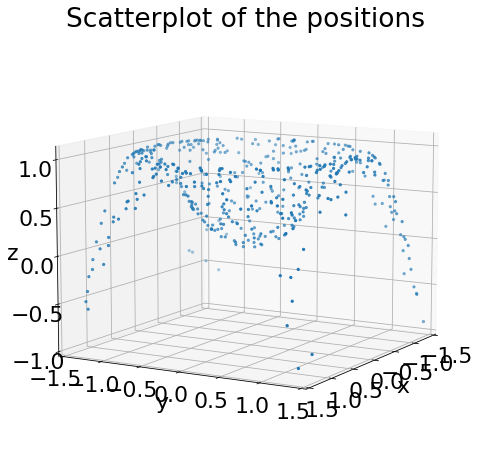

In [23]:
n_train=500
n_valid=50

# generate training inputs
np.random.seed(0)
sigma = 0.1 # noise standard deviation, for the moment it is absent

x_train,y_train,z_train,x_valid,y_valid,z_valid=generateRadialSine(sigma,n_train,n_valid)

x_train_tensor=tf.constant([x_train,y_train])
x_valid_tensor=tf.constant([x_valid,y_valid])
x_train_tensor=tf.transpose(x_train_tensor)
x_valid_tensor=tf.transpose(x_valid_tensor)
fig = plt.figure()
ax = Axes3D(fig,auto_add_to_figure=False)
fig.add_axes(ax)
ax.scatter(x_train, y_train, z_train, marker='.')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim3d([-1.5,1.5])
ax.set_ylim3d([-1.5,1.5])
ax.view_init(10, 30)
plt.title('Scatterplot of the positions')
plt.show();

In [24]:
keras.backend.clear_session()

model = tf.keras.Sequential()
model.add(Dense(5, input_shape=(2,)))
model.add(Dense(5, activation='elu'))
model.add(Dense(5, activation='elu'))
model.add(Dense(5, activation='elu'))
model.add(Dense(1))

# compile the model choosing optimizer, loss and metrics objects
model.compile(optimizer='sgd', loss='mse', metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 15        
                                                                 
 dense_1 (Dense)             (None, 5)                 30        
                                                                 
 dense_2 (Dense)             (None, 5)                 30        
                                                                 
 dense_3 (Dense)             (None, 5)                 30        
                                                                 
 dense_4 (Dense)             (None, 1)                 6         
                                                                 
Total params: 111
Trainable params: 111
Non-trainable params: 0
_________________________________________________________________


In [25]:
bsize = 32
history = model.fit(x=x_train_tensor, y=z_train, 
          batch_size=bsize, epochs=300, 
          validation_data=(x_valid_tensor, z_valid), verbose=0);

In [26]:
x_predicted = np.random.uniform(-1.5, 1.5, 1000)
y_predicted = np.random.uniform(-1.5, 1.5, 1000)
x_predicted_tensor=tf.transpose(tf.constant([x_predicted, y_predicted]))
z_predicted=model.predict(x_predicted_tensor)

32/32 [==============================] - 0s 2ms/step


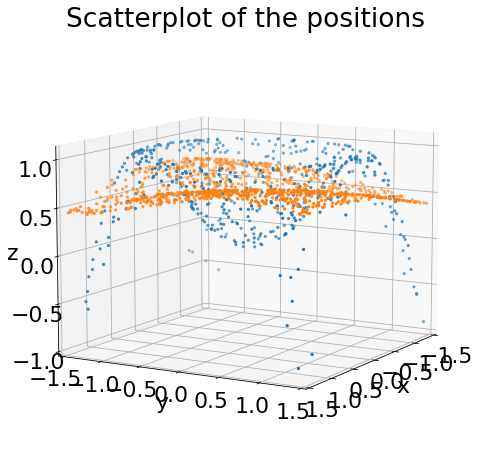

In [27]:

fig = plt.figure()
ax = Axes3D(fig,auto_add_to_figure=False)
fig.add_axes(ax)

ax.scatter(x_train, y_train, z_train, marker='.')
ax.scatter(x_predicted, y_predicted, z_predicted, marker='.')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim3d([-1.5,1.5])
ax.set_ylim3d([-1.5,1.5])
ax.view_init(10, 30)
plt.title('Scatterplot of the positions')
plt.show();